In [36]:
import getpass
import nibabel as nib
from pathlib import Path
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ast
import src.sorting_algorithms as sa

from collections import Counter
import scipy.stats as stats
import itertools
import krippendorff


In [37]:
user = getpass.getuser()

src = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT_Annotation_Summer2023/Completed"

csv_paths = list(Path(src).glob('*.csv'))

In [38]:
rating_resultsdict = {}

for path in csv_paths:
    df = pd.read_csv(path, converters={"result": ast.literal_eval})

    ratings_df = df[(df["type"] == "Rating") & (df["undone"] == False)]

    for res in ratings_df["result"]:
        
        subject_id = res[0][:4]

        if subject_id in rating_resultsdict:
            rating_resultsdict[subject_id].append(res)
        else:
            rating_resultsdict[subject_id] = [res]

In [39]:
#set indicator results to median
for res in rating_resultsdict:
    unique_ids = list(set([res[0] for res in rating_resultsdict[res]]))

    for id in unique_ids:
        filtered = list(filter(lambda value: value[0] == id, rating_resultsdict[res]))
        if len(filtered) > 1:
            median_value = int(np.median([value[1] for value in filtered]))

            new_list = list(filter(lambda value: value[0] != id, rating_resultsdict[res]))
            new_list.append((id, median_value))
            rating_resultsdict[res] = new_list

for v in rating_resultsdict.values():
    v.sort(key=lambda x: x[0])

In [40]:
original_file_path = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/Nifti/"
included_files_path = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT_Annotation_Summer2023/all_nifti"
segmentation_path = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/Segmentations/"

def grid_from_results(resultsdict):

    #Max slices in any lung is 64. 77 * 2 = 154.
    grid = np.full((64,154), 0)

    for subject_id in tqdm(resultsdict.keys()):
        left_lung = Path(included_files_path).glob(subject_id + "*L*.nii")
        left_names = [os.path.basename(path) for path in left_lung]
        left_names.sort()
        index_in_grid = (int(subject_id[2:]) - 1) * 2
        for result in resultsdict[subject_id]:

            if "_R_" in result[0]:
                continue

            grid[left_names.index(result[0]), index_in_grid] = result[1]

        right_lung = Path(included_files_path).glob(subject_id + "*R*.nii")
        right_names = [os.path.basename(path) for path in right_lung]
        right_names.sort()
        index_in_grid = (int(subject_id[2:]) - 1) * 2 + 1
        for result in resultsdict[subject_id]:

            if "_L_" in result[0]:
                continue

            grid[right_names.index(result[0]), index_in_grid] = result[1]

    return grid

In [41]:
rating_grid = grid_from_results(rating_resultsdict)

100%|██████████| 77/77 [00:19<00:00,  3.92it/s]


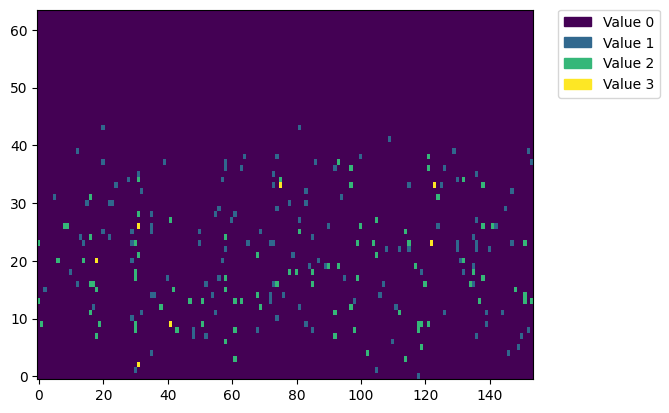

In [42]:
#cmap = colors.ListedColormap(["white", "yellow", "black", "blue", "red"])

values = np.unique(rating_grid.ravel())

im = plt.imshow(rating_grid, origin="lower", aspect="auto")#, cmap=cmap)

colors = [ im.cmap(im.norm(value)) for value in values]

patches = [ mpatches.Patch(color=colors[i], label="Value {l}".format(l=values[i]) ) for i in range(len(values)) ]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()


In [43]:
comparisons = []

data = []

for path in csv_paths:
    
    df = pd.read_csv(path, converters={"result": ast.literal_eval})
    ranking_df = df[(df["type"] == "Ranking") & (df["undone"] == False)]

    for index, row in ranking_df.iterrows():

        diff_lvls = [sa.DiffLevel(abs([int(s) for s in dl if s.isdigit()][0])) for dl in row['diff_levels'].split(", ")]
        
        comparisons.append((row["result"], diff_lvls))

        data = data + row["result"]

data = list(set(data))

r = random.Random(1)

r.shuffle(comparisons)
r.shuffle(data)

In [44]:
def rating_to_mu(rating):
    # With mu = 25 and 1/2 standard deviation spacing
    return 25 + ((rating - 1) * 2 + 1) / 4 * 8.333

In [45]:
mu_dict = {}
flat_result_list = [item for sublist in rating_resultsdict.values() for item in sublist if item[1] >= 0]

for item in flat_result_list:
    
    mu_dict[item[0]] = rating_to_mu(item[1])

In [46]:
sort_alg = sa.TrueSkill(data,initial_mus=mu_dict)

#Add hybrid initial mus
for comparison in tqdm(comparisons):
    sort_alg.inference(random.randint(1,9), comparison[0], comparison[1])

100%|██████████| 1040/1040 [00:02<00:00, 462.02it/s]


In [47]:
results = sort_alg.get_result()

In [48]:
ranking_results = [(item, index) for index, item in enumerate(results)]

In [49]:
def results_to_dict(results):

    resultsdict = {}

    for res in results:
        subject_id = res[0][:4]

        if subject_id in resultsdict:
            resultsdict[subject_id].append(res)
        else:
            resultsdict[subject_id] = [res]

    for v in resultsdict.values():
        v.sort(key=lambda x: x[0])

    return resultsdict

In [50]:
ranking_resultsdict = results_to_dict(ranking_results)

100%|██████████| 73/73 [00:17<00:00,  4.24it/s]


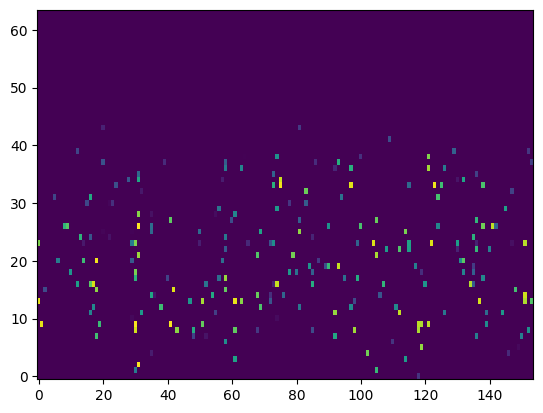

In [51]:
ranking_grid = grid_from_results(ranking_resultsdict)
plt.imshow(ranking_grid, origin="lower", aspect="auto")
plt.show()

In [52]:
def get_distr_from_ratings(flat_ratings):
    filtered = list(filter(lambda value: value > 0, flat_ratings))
    c = Counter(filtered)
    return [c[i]/len(filtered) for i in range(1,4)]

In [53]:
flat_ratings = [res[1] for res in flat_result_list]
distr = get_distr_from_ratings(flat_ratings)
indexes = [int(np.round(distr[i]*len(results))) for i in range(len(distr))]

In [54]:
all_ratings = [i + 1 for i in range(len(distr)) for _ in range(indexes[i])]
distributed_ratings = list(zip(results, all_ratings))

dist_rating_resultsdict = results_to_dict(distributed_ratings)
dist_rating_grid = grid_from_results(dist_rating_resultsdict)

100%|██████████| 73/73 [00:17<00:00,  4.21it/s]


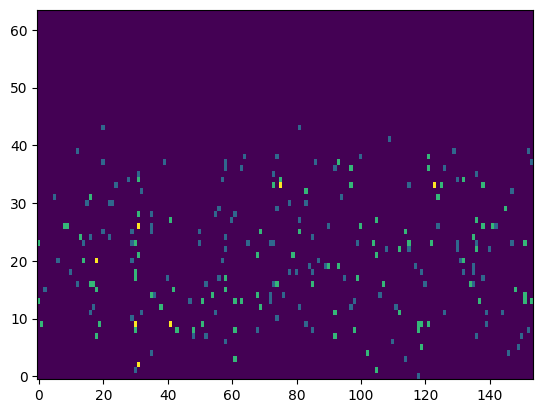

In [55]:
plt.imshow(dist_rating_grid, origin="lower", aspect="auto")
plt.show()

In [56]:
def mean_squared_neighbour_difference(grid):
    
    squared_differences = []

    for col in range(grid.shape[1]):
        for row in range(grid.shape[0] - 1):
            #Both slices of the adjacent slices has received values
            if grid[row,col] > 0 and grid[row + 1,col] > 0:
                squared_differences.append((grid[row,col] - grid[row + 1,col])**2)

    print("Neighbouring slices present:", len(squared_differences))
    print(squared_differences)
    return np.mean(squared_differences)


print(mean_squared_neighbour_difference(ranking_grid))
print(mean_squared_neighbour_difference(rating_grid))
print(mean_squared_neighbour_difference(dist_rating_grid))

Neighbouring slices present: 14
[169, 1156, 3481, 9, 9025, 625, 841, 169, 4, 25, 11025, 841, 17424, 100]
3206.714285714286
Neighbouring slices present: 14
[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
0.2857142857142857
Neighbouring slices present: 14
[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]
0.42857142857142855


In [57]:
c_rating = Counter(rating_grid.flat)
c_dist_rating = Counter(dist_rating_grid.flat)
print(c_rating)
print(c_dist_rating)

Counter({0: 9626, 1: 131, 2: 92, 3: 7})
Counter({0: 9626, 1: 131, 2: 92, 3: 7})


In [58]:
def get_non_neighbour_differences(grid):

    indexes = []

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if rating_grid[i,j] > 0:
                indexes.append((i, j))

    index_combinations = list(itertools.combinations(indexes, 2))

    differences = []

    for combination in index_combinations:
        i1 = combination[0]
        i2 = combination[1]

        if i1[1] == i2[1] and abs(i1[0] - i2[0]) <= 1:
            continue

        differences.append(abs(grid[i1] - grid[i2]))
    return differences

In [59]:
def get_neighbour_differences(grid):
    
    differences = []

    for col in range(grid.shape[1]):
        for row in range(grid.shape[0] - 1):
            #Both slices of the adjacent slices has received values
            if grid[row,col] > 0 and grid[row + 1,col] > 0:
                differences.append(abs(grid[row,col] - grid[row + 1,col]))

    return differences

In [60]:
def get_neighbour_annotations(grid):
    
    differences = [[], []]

    for col in range(grid.shape[1]):
        for row in range(grid.shape[0] - 1):
            #Both slices of the adjacent slices has received values
            if grid[row,col] > 0 and grid[row + 1,col] > 0:
                differences[0].append(grid[row,col])
                differences[1].append(grid[row + 1,col])
                #differences.append(abs(grid[row,col] - grid[row + 1,col]))

    return differences

In [61]:
def calculate_pointbiserial(grid):

    non_diff = get_non_neighbour_differences(grid)
    diff = get_neighbour_differences(grid)

    x = non_diff + diff
    y = [0] * len(non_diff) + [1] * len(diff)

    return stats.pointbiserialr(x,y)

In [62]:
# -1 is best
# Only have 14 neighbouring slices as of now, interesting to see how these numbers change as the sample size increases...
print("Rating:", calculate_pointbiserial(rating_grid))
print("Ranking:", calculate_pointbiserial(ranking_grid))
print("Distributed Ratings:", calculate_pointbiserial(dist_rating_grid))

Rating: SignificanceResult(statistic=-0.010897494696174672, pvalue=0.07699058674325261)
Ranking: SignificanceResult(statistic=-0.015958016716016758, pvalue=0.009605435145487552)
Distributed Ratings: SignificanceResult(statistic=-0.005045424491774998, pvalue=0.4129342180919569)


In [64]:
rating_annotations = get_neighbour_annotations(rating_grid)
ranking_annotations = get_neighbour_annotations(ranking_grid)
dist_rating_annotations = get_neighbour_annotations(dist_rating_grid)


#Right now, the alpha is very misleading as the full range of values is not known...

#This exemplifies the issue.
sanity_check = [[220, 219, 219, 219, 220, 220, 220],[219, 220, 220, 220, 219, 219, 219]]

#There is a value_domain parameter, but unclear how it works.

print(rating_annotations)
print(ranking_annotations)
print(krippendorff.alpha(rating_annotations, level_of_measurement="ordinal"))
print(krippendorff.alpha(ranking_annotations, level_of_measurement="ordinal"))
print(krippendorff.alpha(dist_rating_annotations, level_of_measurement="ordinal"))

[[2, 2, 2, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2]]
[[213, 148, 136, 79, 47, 93, 60, 224, 130, 200, 23, 70, 153, 202], [226, 182, 77, 82, 142, 68, 31, 211, 132, 205, 128, 41, 21, 212]]
0.595467032967033
0.6199859254046446
0.4873920722135009
